#### - replace gait periodes by single steps (step detection von elisa, alt.: end_index detection)
#### - implement parameters
#### - implement PSTHs for parameters
#### - implement max_value for parameters
#### - export function
####
####
#### - Kamera Kalibrierung aufnehmen
#### - Outlier Frames 200x, Re-Trainieren
#### - GaitAnalysis aus Paper?

# Walkthrough 2D

In [1]:
from Analysis.gaitanalysis import Recording2D
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
bot = Recording2D(filepath="/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Inken Analyse/Dummy Data Inken/2-1413_Catwalk_Maus01_prä-OP1_20220315DLC_resnet50_2-1413 CatwalkMay25shuffle1_600000.csv", recorded_framerate=30)
bot.metadata

{'recording_date': '20220315', 'animal': 'Maus01', 'paradigm': 'prä-OP1'}

In [3]:
bot.run()#video_filepath='/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Inken Analyse/Dummy Data Inken/2-1413_Catwalk_Maus01_prä-OP1_20220315.mp4'
bot.bodyparts['Snout'].df.head()

Distorted Points reflect the real-world distances poorly.
 To undistort, pass an intrinsic_camera_calibration_filepath, the xy_offset of cropping and the video_filepath!


,x,y,likelihood,speed_cm_per_s,rolling_speed_cm_per_s,immobility
0,-2.550146,-50.675496,0.999996,NaN,NaN,False
1,-1.394735,-51.250638,0.998681,38.719329,25.700926,False
2,-1.478290,-50.834159,0.999990,12.743329,31.198141,False
3,-0.911811,-51.474131,0.988800,25.640121,29.450684,False
4,0.598191,-51.971032,0.999996,47.689786,25.393570,False


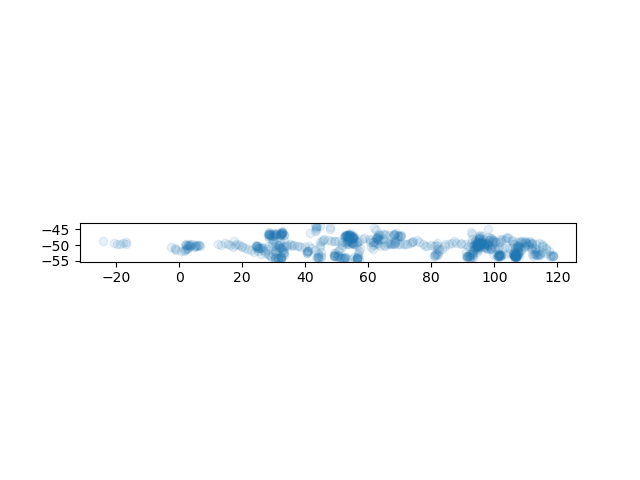

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(bot.bodyparts['Snout'].df['x'], bot.bodyparts['Snout'].df['y'], alpha = 0.1)
plt.show()

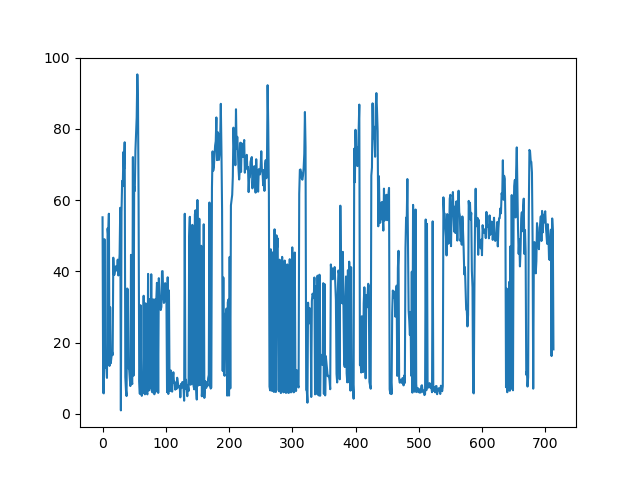

In [5]:
bot.run_gait_analysis()
plt.close()

plt.plot(bot.angle_hindkneeleft.parameter_array)
plt.show()

## Proof undistort points

In [6]:
import imageio.v3 as iio
import cv2
import pickle


In [7]:
df = pd.read_hdf("196_F7-27_220826_OTT_Bottom_synchronizedDLC_resnet152_OT_BottomCam_finalSep20shuffle1_550000filtered.h5")
df = df.drop('scorer', axis=1)
df.columns = df.iloc[0, :]+ '_' + df.iloc[1, :]
df = df.drop([0, 1], axis=0)
df = df.reset_index()
df = df.drop('index', axis=1)
df = df.astype(float)

NameError: name 'pd' is not defined

In [ ]:
def load_intrinsic_camera_calibration(filepath_intrinsic_calibration: Path, xy_offset: Tuple[int, int]) -> None:
    with open(filepath_intrinsic_calibration, 'rb') as io:
        intrinsic_calibration = pickle.load(io)
    adjusted_intrinsic_calibration = intrinsic_calibration.copy()
    intrinsic_calibration_video_size = intrinsic_calibration['size']
    x_offset, y_offset = xy_offset[0], xy_offset[1]
    adjusted_K = intrinsic_calibration['K'].copy()
    adjusted_K[0][2] = adjusted_K[0][2] - x_offset
    adjusted_K[1][2] = adjusted_K[1][2] - y_offset
    return adjusted_K, intrinsic_calibration['D']

In [ ]:
image=iio.imread('/Users/kobel/Downloads/196_F7-27_220826_OTT_Bottom_synchronizedDLC_resnet152_OT_BottomCam_finalSep20shuffle1_550000_filtered_labeled.mp4', index=5700)

In [ ]:
size = (image.shape[1], image.shape[0])

In [ ]:
K, D = load_intrinsic_camera_calibration('/Users/kobel/Downloads/OneDrive_3_30/Bottom_checkerboard_intrinsic_calibration_results.p', xy_offset=(136, 452))

In [ ]:
dst_list = []
for bp in ['Snout', 'TailBase', 'HindPawLeft', 'HindPawRight', 'ForePawLeft', 'ForePawRight', 'WristLeft', 'WristRight', 'TailQuarterAnt', 'TaiMiddle', 'TailQuarterPost', 'TailEnd']:
    pt = df[[bp + '_x', bp + '_y']].copy().values
    newcameramtx, _ = cv2.getOptimalNewCameraMatrix(K, D, size, 1, size)
    dst = cv2.undistortPoints(pt, K, D, None, newcameramtx)
    dst = np.squeeze(dst)
    dst_list.append(dst)

In [ ]:
plt.close()
fig, ax = plt.subplots()
ax.set_aspect('equal')
#plt.imshow(undistort_fisheye_image_for_inspection(image=image, K=K, D=D, size=size))
# issue: image is rectified, points are not -> plotting points over image makes no sense
for dst in dst_list:
    plt.scatter(dst[5700][0], dst[5700][1])
plt.show()